<div style='text-align: center;'><h2 style='color:blue; display:inline;'>Boca</h2><h2 style='color:red; display:inline;'>River</h2> <h2 style='color:black; display:inline;'>Player Classification</h2></div)

In [152]:
import numpy as np
import cv2
import matplotlib
import pywt
from matplotlib import pyplot as plt
%matplotlib inline

<h3 style='color:black'>(1) Preprocessing: Detect face and eyes</h3>

#### When examining an image, our primary method for person identification is often based on facial features. Images may feature multiple faces, and faces can be obscured or unclear. Our initial pre-processing step involves face detection. Once a face is successfully detected, the subsequent step involves eye detection. If both eyes are detected, we retain the image; otherwise, we discard it. This process helps filter and focus on images with clear and recognizable facial structures</h4>

#### OpenCV is ourt tool to detect facial features such as face and eyes

In [153]:
# First example with one of our players
img = cv2.imread('./test_images/armani1.jpg')
img.shape


(180, 260, 3)

In [ ]:
# The dimension for pictures is a 180x260 matrix wiht 3 RGB layers for the colors

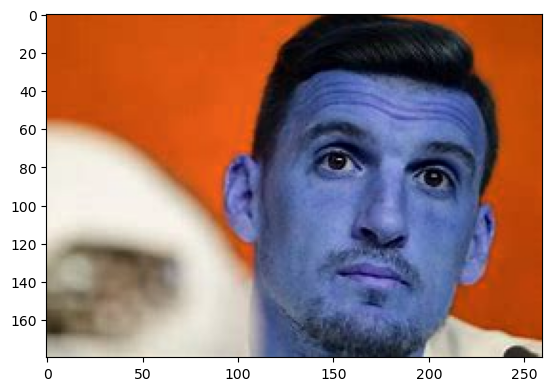

In [154]:
plt.imshow(img)

In [155]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # This command allow us to remove the RGB layers
gray.shape

(180, 260)

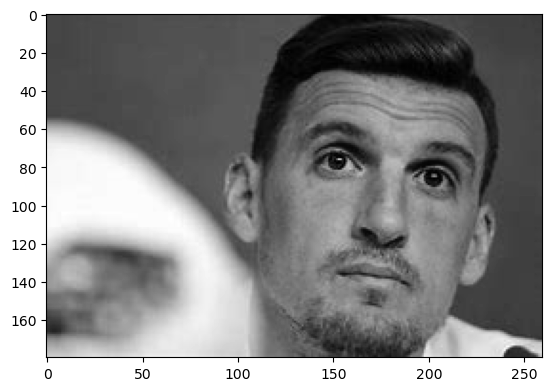

In [157]:
plt.imshow(gray, cmap='gray')

In [158]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml') # This is be the face detector
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml') # This is the eyes detector
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
#scaleFactor: A parameter specifying how much the image size is reduced at each image scale. In this case, it is set to 1.3.
#minNeighbors: This is a parameter specifying how many neighbors each candidate rectangle should have to retain it. 
#              Higher values result in fewer detections but with higher quality. In this case, it is set to 5
faces
# The result for faces is thw following: represents a single rectangle that indicates the location and size of a detected face
#x: X-coordinate of the top-left corner of the rectangle (109 in this case).
#y: Y-coordinate of the top-left corner of the rectangle (28 in this case).
#width: Width of the rectangle (136 in this case).
#height: Height of the rectangle (136 in this case)

array([[109,  28, 136, 136]])

In [159]:
(x,y,w,h) = faces[0]
x,y,w,h

(109, 28, 136, 136)

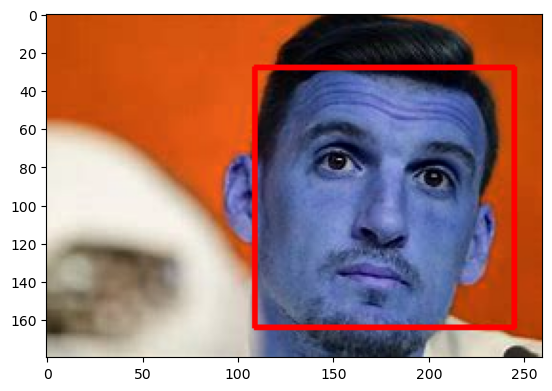

In [160]:
# Let's visualize the rectangle detected in "faces"

face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

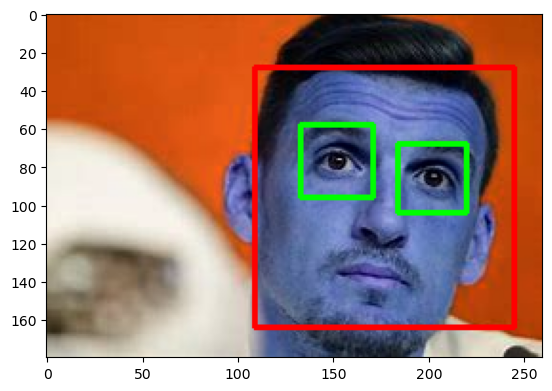

In [161]:
cv2.destroyAllWindows() # This line closes all OpenCV windows. 
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w] # Region of insterest ROI for both versions
    roi_color = face_img[y:y+h, x:x+w]
    # This loop iterates over the list of eyes detected within the region of interest (ROI) corresponding to the detected face
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

<h3 style='color:Black'>(2) Preprocessing: Crop the facial region of the image</h3>

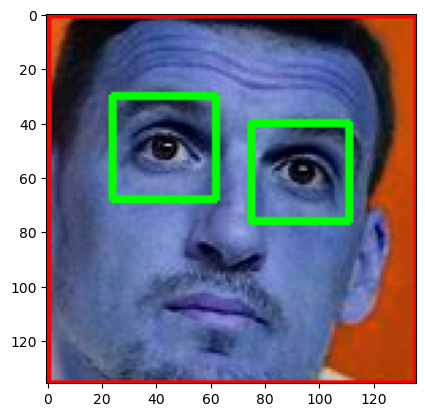

In [162]:
# Here we can see how the image is cropped
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [163]:
cropped_img = np.array(roi_color)
cropped_img.shape

(136, 136, 3)

<h3 style='color:Black'>(3) Preprocessing: Use wavelet transform as a feature for traning our model</h3>

#### In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

### Wavelet transform

In [164]:
 def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )     #Convert to grayscale
    imArray =  np.float32(imArray)   # Converting the image to float
    imArray /= 255; # Normalizing the values of the pixels
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level) # compute the 2D wavelet decomposition of the image

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  # This effectively removes the low-frequency components. (Direct current)

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

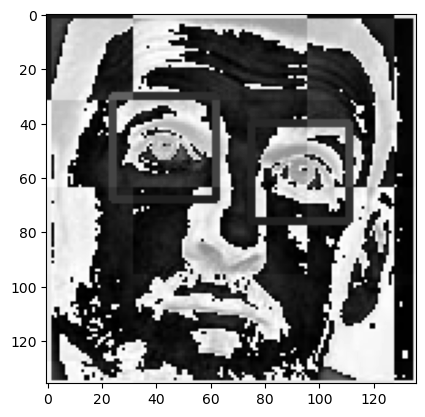

In [165]:
# Let's see how the Wavelet works
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

#### You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose.

<h3 style='color:black'>(3) Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region</h3>

####  Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [166]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

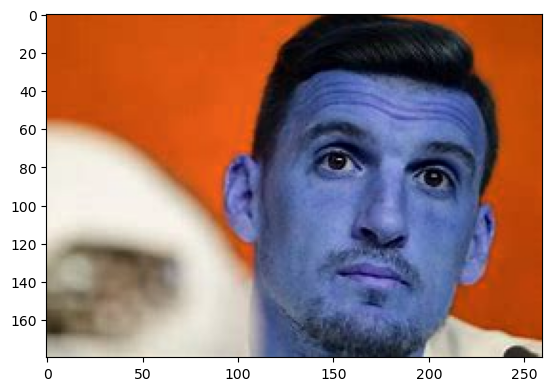

In [167]:
original_image = cv2.imread('./test_images/armani1.jpg')
plt.imshow(original_image)

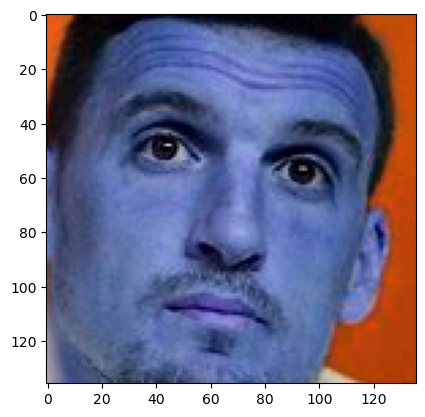

In [168]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/armani1.jpg')
plt.imshow(cropped_image)

**In below image face is not very clear and it doesn't have two eyes clearly visible**

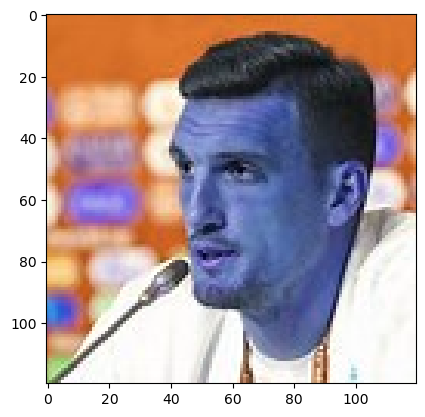

In [169]:
org_image_obstructed = cv2.imread('./test_images/armani2.jpg')
plt.imshow(org_image_obstructed)

In [170]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/armani2.jpg')
cropped_image_no_2_eyes

**Above cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training**

#### Lets specify the paths to work with

In [171]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [172]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [173]:
img_dirs

['./dataset/cropped',
 './dataset/dario_benedetto',
 './dataset/edinson_cavani',
 './dataset/franco_armani',
 './dataset/miguel_borja',
 './dataset/salomon_rondon']

**Here we go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code**

In [177]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

#### If needed, you can activate the print inside de loop for entry, and detect other images that are corrupt.

In [184]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    #count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        #print(entry.path)
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./dataset/cropped/dario_benedetto
Generating cropped images in folder:  ./dataset/cropped/edinson_cavani
Generating cropped images in folder:  ./dataset/cropped/franco_armani
Generating cropped images in folder:  ./dataset/cropped/miguel_borja
Generating cropped images in folder:  ./dataset/cropped/salomon_rondon


### Manually examine cropped folder and delete any unwanted images

In [185]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1] #This line extracts the name of the celebrity from the directory path. 
                                            #It does this by splitting the directory path using the '/' character 
                                            #as a separator and taking the last element of the resulting list (i.e., the name of the directory itself).
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'dario_benedetto': ['./dataset/cropped/dario_benedetto\\dario_benedetto100.png',
  './dataset/cropped/dario_benedetto\\dario_benedetto101.png',
  './dataset/cropped/dario_benedetto\\dario_benedetto102.png',
  './dataset/cropped/dario_benedetto\\dario_benedetto103.png',
  './dataset/cropped/dario_benedetto\\dario_benedetto104.png',
  './dataset/cropped/dario_benedetto\\dario_benedetto105.png',
  './dataset/cropped/dario_benedetto\\dario_benedetto106.png',
  './dataset/cropped/dario_benedetto\\dario_benedetto107.png',
  './dataset/cropped/dario_benedetto\\dario_benedetto108.png',
  './dataset/cropped/dario_benedetto\\dario_benedetto109.png',
  './dataset/cropped/dario_benedetto\\dario_benedetto110.png',
  './dataset/cropped/dario_benedetto\\dario_benedetto111.png',
  './dataset/cropped/dario_benedetto\\dario_benedetto112.png',
  './dataset/cropped/dario_benedetto\\dario_benedetto113.png',
  './dataset/cropped/dario_benedetto\\dario_benedetto114.png',
  './dataset/cropped/dario_benedetto

In [186]:
# Now we need to assign a number to represent each player

class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'dario_benedetto': 0,
 'edinson_cavani': 1,
 'franco_armani': 2,
 'miguel_borja': 3,
 'salomon_rondon': 4}

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [187]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [192]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(248, 4096)

### Once the data is cleared. Now we are ready to train our model

### Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [198]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [202]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [203]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.773969,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.510242,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.811522,{'logisticregression__C': 1}


In [204]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [205]:
best_estimators['svm'].score(X_test,y_test)

0.6774193548387096

In [206]:
best_estimators['random_forest'].score(X_test,y_test)

0.532258064516129

In [207]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7419354838709677

In [ ]:
### Considering the GridSearch and the score for the X_test and Y_test, we'll use Logistic_regression

In [209]:
best_clf = best_estimators['logistic_regression']

In [210]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[16,  2,  0,  0,  0],
       [ 0,  5,  1,  0,  2],
       [ 1,  1,  8,  0,  0],
       [ 0,  2,  0,  8,  0],
       [ 1,  2,  1,  3,  9]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

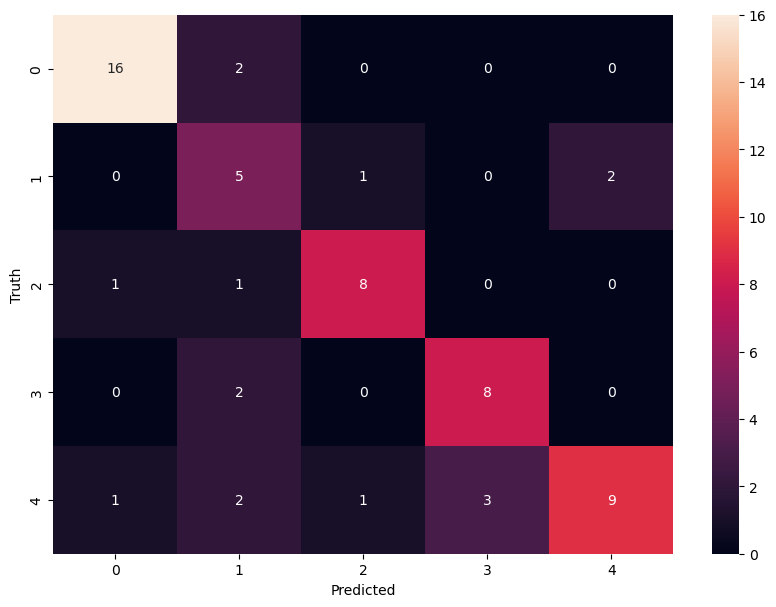

In [211]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [212]:
class_dict

{'dario_benedetto': 0,
 'edinson_cavani': 1,
 'franco_armani': 2,
 'miguel_borja': 3,
 'salomon_rondon': 4}

### Save the trained model

In [213]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

### Save class dictionary

In [214]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))